# Introduction to Deep Learning

## Peer-graded Assignment: Histopathologic Cancer Detection Kaggle Mini-Project

## 0. Introduction

This notebook is for the assignment of the course Introduction to Deep Learning : Week 3 Cancer Detection Kaggle Mini-Project.

>The assignment is to apply the CNN algorithm. The mini project is hosted on Kaggle ("https://www.kaggle.com/c/histopathologic-cancer-detection/overview")

>The method is used for identifying metastatic cancer from images.

The notebook contains the following parts:

1. Exploratory data analysis

2. Applying the CNN algorithm

3. Conclusion

## 1. EDA

### 1.1 Libraries and Data

In [1]:
# Basic libraries
import os
import gc  # Garbage collection to free memory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm.notebook import trange  # tqdm for progress bars

# Image handling
from PIL import Image
import cv2  # OpenCV for image processing

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TensorFlow/Keras for deep learning
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, 
#                                      Dropout, BatchNormalization, Activation)
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# garbage collection
import gc

2025-04-28 07:21:02.345063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745824862.534968      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745824862.591921      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
# Load Data
base_path = "/kaggle/input/histopathologic-cancer-detection/"
train_path = os.path.join(base_path, "train")
df = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))})  # Get list of all image file paths
df['id'] = df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])  # Extract image ID from path
labels = pd.read_csv(os.path.join(base_path, "train_labels.csv"))  # Load labels
df = df.merge(labels, on="id")  # Merge image paths with labels

### 1.2 Exploration

In [4]:
df.shape
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   path    220025 non-null  object
 1   id      220025 non-null  object
 2   label   220025 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


path     0
id       0
label    0
dtype: int64

From the general information, it can be found that:

1. There are about 220k images stored in the paths;

2. There are no missing values;

3. The images should be retrieved from the paths.

In [5]:
# Load preview data
def load_data(N, df):
    X, y = [], []
    for i, row in df.iloc[:N].iterrows():
        img = Image.open(row['path'])  # Read image
        X.append(np.array(img))  # Convert to NumPy array
        y.append(row['label'])  # Get corresponding label
    return np.array(X), np.array(y)

In [6]:
N = df.shape[0]  # Set number of images to load (use all available)
# N = 10000 # For the preview, only load part of the data
# N = df["path"].size
X, y = load_data(N, df)  # Load images and labels

In [7]:
# check the image data
print(X.shape)
print(y.shape)
np.unique(y)

(10000, 96, 96, 3)
(10000,)


array([0, 1])

The dataset contains:

>(1) X: Image data expressed in a 3D array 96 × 96 × 3 (Height × Width × Color channels).

>(2) y: (0, 1) Labels of the results.

In [8]:
# 3. Normalize pixel values to [0, 1]
# X = X / 255.0

In the next, let us randomly sample and preview some of the data

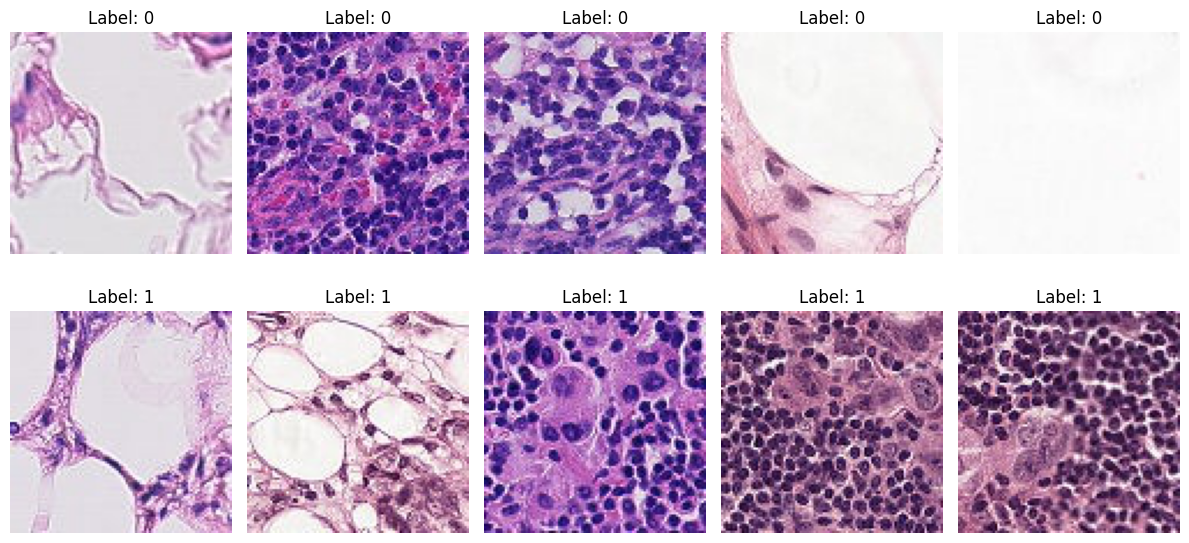

In [9]:
# Visualize some images
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for label in [0, 1]:
    samples = df[df.label == label].sample(5, random_state=1)  # Sample 5 images per class
    for i, path in enumerate(samples['path']):
        ax = axs[label, i]
        ax.imshow(Image.open(path))  # Display image
        ax.set_title(f"Label: {label}")
        ax.axis('off')
plt.tight_layout()
plt.show()

Next, I check whether the categories are biased by plotting a bar chart, which means the (0, 1) labels should be balanced.

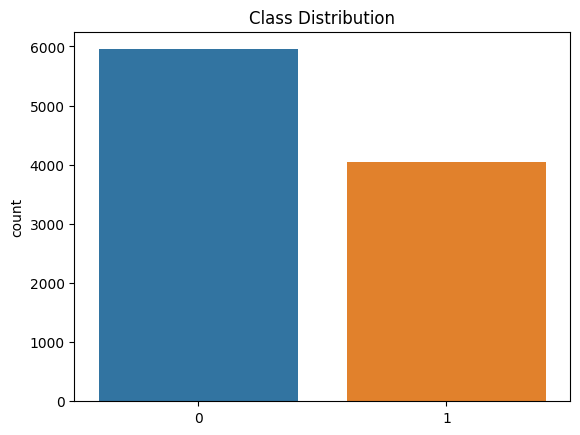

In [10]:
sns.countplot(x=y)
plt.title("Class Distribution")
plt.show()

It seems there are more 0-labeled data, and the data size seems to be large engough. Now let us investigate the difference between the differently labeled data. First, I conduct a t-SNE visualization.

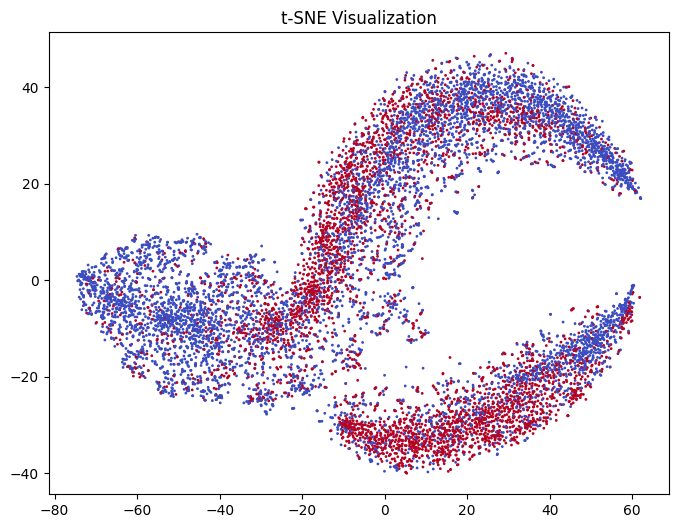

In [11]:
# Visualize image embeddings using t-SNE
flat_X = X.reshape(X.shape[0], -1)  # Flatten images
pca = PCA(n_components=50).fit_transform(flat_X)  # Reduce dimensionality
tsne = TSNE(n_components=2, random_state=42).fit_transform(pca)  # Apply t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], c=y, cmap='coolwarm', s=1)
plt.title("t-SNE Visualization")
plt.show()

The visualization shows the two categories have different spread based on 2D-representation. The blue color represents the negative, while the red color represent the positive samples. From the observation, it suggests the positive samples are a subset of the negative samples in a 2D-representation.

Second, the two categorites are compared based on R, G, B color representations [0, 255], where

>(1) 0 means no color intensity (black for the channel); 

>(2) 255 means the maximum intensity (brightest for the channel).

In [12]:
# Split the preview data
positive_samples = X[y == 1]
negative_samples = X[y == 0]

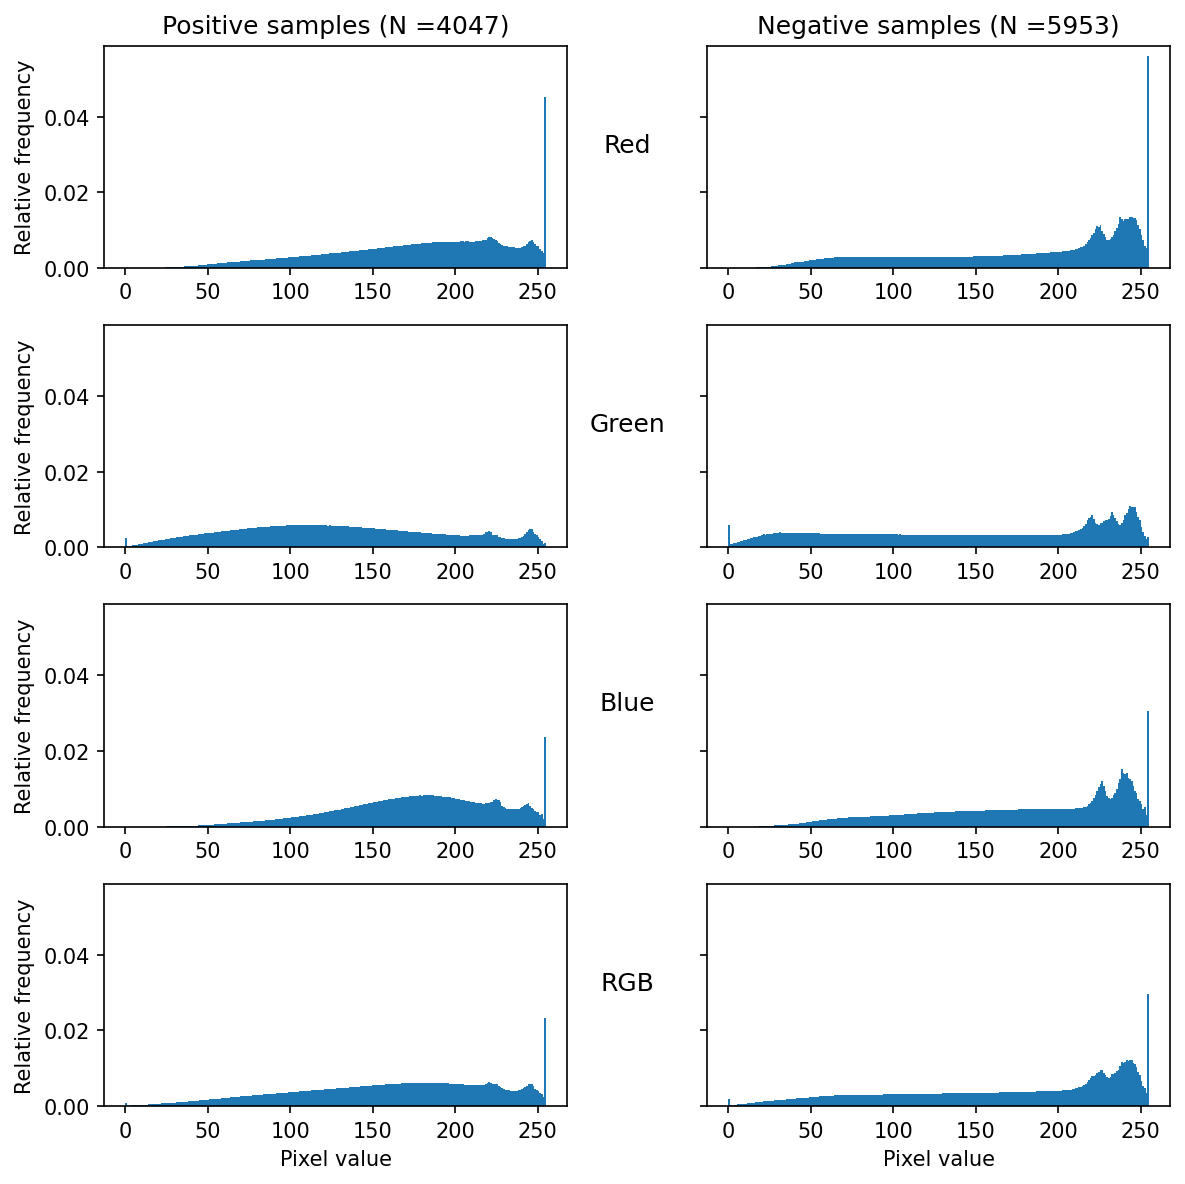

In [13]:
nr_of_bins = 256
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

Based on the observations, it suggests differences in systematic patterns:

>(1) (R, G, B) chaneles of positive samples tend to have bell-curve shape located at the relatively middle points on the x-axis;

>(2) (R, G, B) chaneles of negative samples tend to spead more evenly from [0, 255]. However, it also shows a heavy right tail in all the three channels.

This is consistent with the t-SNE visualization. At last, let us take a look at the brightness of the images.

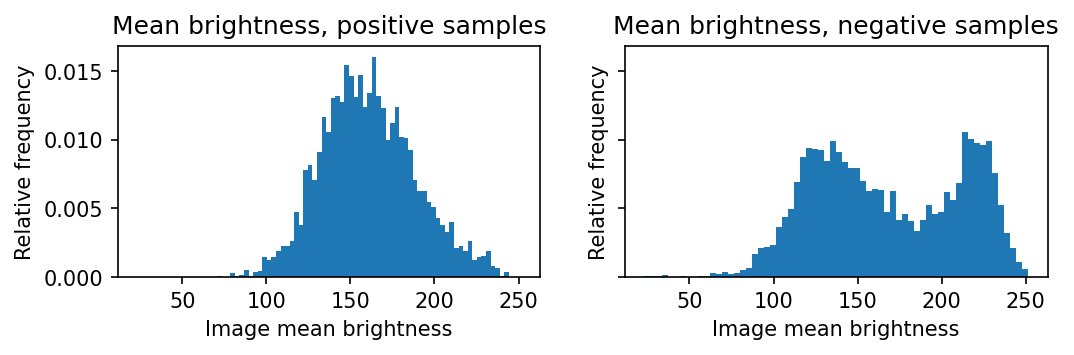

In [14]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

Once again, it suggests the difference consistantly: the positive samples tend to be concentrated locally.

### 2.3 EDA summary

From the EDA analysis, it can be concluded that:

>(1) The data has 220k samples, and the ratio between positive and negative relatively balanced. No sample has missing values.

>(2) There indicates obvious difference between the two categories by visualizations of t-SNE, and RGB-channel and brightness distributions.

## 2. CNN application

## 2.1 Model building

Let us clear the previewed samples, and reload the entire dataset.

In [15]:
# Collect garbage
# positives_samples = None
# negative_samples = None
# X = None
# y = None
# gc.collect();

In [16]:
# N = df.shape[0]  # Set number of images to load
# N = 10000 # For the preview, only load part of the data
# X,y = load_data(N=N,df=df)

# Normalize pixel values to [0, 1]
X = X / 255

The data is splitted into the train and test datasets in a 80-20 ratio.

In [17]:
# Shuffle and split data into training and validation sets
np.random.seed(42)
idx = np.arange(len(y))
np.random.shuffle(idx)
X, y = X[idx], y[idx]  # Shuffle by labels
split_idx = int(0.8 * len(y))  # 80% training, 20% validation
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

Now, let us build the CNN architecture.

In [18]:
# Network parameter settings
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout_conv = 0.3
dropout_dense = 0.5

#initialize the model
model = Sequential()

# Add layers to it
# conv block 1
model.add(Conv2D(first_filters, kernel_size, input_shape = (96, 96, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(first_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

# conv block 2
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(second_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# conv block 3
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Conv2D(third_filters, kernel_size, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

# a fully connected layer at the end
model.add(Flatten())
model.add(Dense(256, use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(dropout_dense)) # Output layer for binary classification

# final output
model.add(Dense(1, activation = "sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745825013.227018      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Then, the model is complied.

In [19]:
# Compile model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', AUC(), Precision(), Recall()]
)

## 2.2 Model training

Now the model is ready for training.

In [20]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=50,
    epochs=5,                # 5 epochs are selected
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5


I0000 00:00:1745825023.579212     100 service.cc:148] XLA service 0x783118002200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745825023.579682     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745825024.220454     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/160 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5889 - auc: 0.6316 - loss: 0.8023 - precision: 0.4555 - recall: 0.6308

I0000 00:00:1745825031.301106     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.7444 - auc: 0.8038 - loss: 0.5617 - precision: 0.6794 - recall: 0.7030 - val_accuracy: 0.5330 - val_auc: 0.6179 - val_loss: 2.5109 - val_precision: 0.4604 - val_recall: 0.9725 - learning_rate: 0.0010
Epoch 2/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7969 - auc: 0.8712 - loss: 0.4490 - precision: 0.7667 - recall: 0.7244 - val_accuracy: 0.4910 - val_auc: 0.6480 - val_loss: 3.3408 - val_precision: 0.4392 - val_recall: 0.9850 - learning_rate: 0.0010
Epoch 3/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8202 - auc: 0.8873 - loss: 0.4148 - precision: 0.8023 - recall: 0.7404 - val_accuracy: 0.6070 - val_auc: 0.8271 - val_loss: 1.3455 - val_precision: 0.5046 - val_recall: 0.9525 - learning_rate: 0.0010
Epoch 4/5
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.8332 - auc: 0.8937 - loss: 0.4027 - precision: 0.8079 - recall: 0.7630 - val_accuracy: 0.7100 - val_auc: 0.8882 - val_loss: 0.7297 - val_precisio

In [21]:
# Evaluation indices
val_loss, val_acc, val_auc, val_prec, val_rec = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, AUC: {val_auc:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}")

Validation Loss: 0.3993, Accuracy: 0.8310, AUC: 0.8979, Precision: 0.7902, Recall: 0.7862


The results show a relative good fit.

In [3]:
# Evaluation by confusion matrix
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-cancer (0)", "Cancer (1)"])
disp.plot(cmap="Blues")  # You can choose other colormaps too
plt.title("Confusion Matrix on Validation Set")
plt.show()


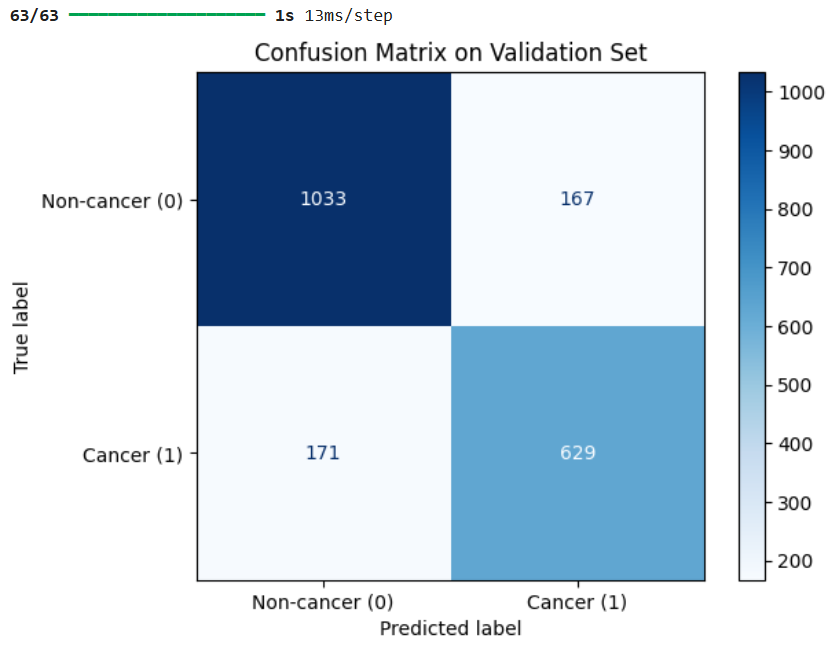

## 3. Conclusion

In this notebook, I apply the CNN model to predict negativity/positivity from Pathology scan images.

## 4. Create a submission

The final step for the competition is getting the results for submission

In [23]:
# Create submission
base_test_dir = os.path.join(base_path, 'test')
test_files = glob(os.path.join(base_test_dir, '*.tif'))  # List all test image files
submission = pd.DataFrame()
file_batch = 5000  # Predict in batches to avoid memory issues
max_idx = len(test_files)

for idx in range(0, max_idx, file_batch):
    print(f"Indexes: {idx} - {min(idx+file_batch, max_idx)}")
    test_df = pd.DataFrame({'path': test_files[idx:idx+file_batch]})
    test_df['id'] = test_df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])  # Extract image ID
    test_df['image'] = test_df['path'].apply(cv2.imread)  # Read image
    K_test = np.stack(test_df['image'].values) / 255.0  # Normalize
    predictions = model.predict(K_test, verbose=1)  # Predict using model
    test_df['label'] = predictions  # Store predictions
    submission = pd.concat([submission, test_df[['id', 'label']]])  # Add to submission

submission.to_csv("submission.csv", index=False, header=True)  # Save to CSV
submission.head()

Indexes: 0 - 5000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Indexes: 5000 - 10000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 10000 - 15000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 15000 - 20000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 20000 - 25000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Indexes: 25000 - 30000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 30000 - 35000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Indexes: 35000 - 40000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Indexes: 40000 - 45000
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Indexes: 45000 - 50000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 50000 - 55000
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Indexes: 55000 - 57458
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0.561315
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0.047696
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0.028574
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0.775360
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0.270344


In [24]:
# Submission check
print("Files in working directory:", os.listdir('/kaggle/working'))  # show working directory
print(os.listdir())  # Check if 'submission.csv' is actually saved

Files in working directory: ['submission.csv', '.virtual_documents']
['submission.csv', '.virtual_documents']


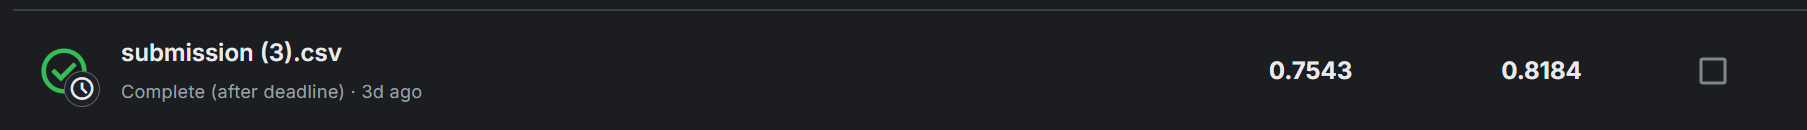